In [1]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
%config InlinBackend.figure_format="retina"
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负

In [2]:
#生成大气湍流模糊核
def turbulence_PSF(input,k):
    [m, n] = input.shape
    PSF = np.zeros((m, n))
    p = m / 2
    q = n / 2
    for u in range(m):
        for v in range(n):
            PSF[u, v]=math.exp(-k*((u-p)*(u-p)+(v-q)*(v-q))**(5/6))
    PSF1= np.fft.ifft2(PSF)
    PSF1 = np.abs(PSF1)
    PSF1 = PSF1 / PSF1.sum()  # 模糊核的权重和为1
    return PSF1

In [3]:
#此函数生成的运动模糊核是由旋转来控制运动方向
def make_PSF(kernel_size=15, angle=60):
    PSF = np.diag(np.ones(kernel_size))  # 初始模糊核的方向是-45度
    angle = angle + 45  # 抵消-45度的影响
    #图像旋转是一种几何变换，实现图像几何变换有两步：先生成变换算子，再执行变换
    M = cv2.getRotationMatrix2D((kernel_size / 2, kernel_size / 2), angle, 1)  # 生成旋转算子
    PSF = cv2.warpAffine(PSF, M, (kernel_size, kernel_size),flags=cv2.INTER_LINEAR)
    PSF = PSF / PSF.sum()    #模糊核的权重和为1
    return PSF

In [4]:
#此函数扩展PSF0，使之与image0一样大小
def extension_PSF(image0,PSF0):
    [img_h,img_w] = image0.shape
    [h,w] = PSF0.shape
    PSF=np.zeros((img_h,img_w))
    PSF[0:h, 0:w] =PSF0[0:h, 0:w]
    return PSF

In [10]:
# 在频域对图片进行模糊
def make_blurred(input, PSF):
    input_fft = np.fft.fft2(input)  # 进行二维数组的傅里叶变换
    PSF_fft = np.fft.fft2(PSF)
    blurred = np.fft.ifft2(input_fft * PSF_fft)
    blurred=np.abs(blurred)
    return blurred

In [7]:
def inverse(input, PSF):  # 逆滤波
    input_fft = np.fft.fft2(input)
    PSF_fft = np.fft.fft2(PSF)+1e-3  # 为了避免分母为零，将PSF的傅里叶变换加一个极小值eps
    result = np.fft.ifft2(input_fft / PSF_fft)  # 
    result = np.abs(result)
    return result.copy()

In [8]:
def Pseudo_inverse(input, PSF, w,k):  # 伪逆滤波
    input_fft = np.fft.fft2(input)
    input_sfft=np.fft.fftshift(input_fft)
    PSF_fft = np.fft.fft2(PSF)  
    PSF_sfft=np.fft.fftshift(PSF_fft)
    [M,N]=input_fft.shape
    c0=int((M-1)/2)
    c1=int((N-1)/2)    
    F=np.zeros((M,N))+0j
    for u in range(M):
        for v in range(N):
            D=np.sqrt((u-c0)**2+(v-c1)**2)
            if D<=w:
                F[u,v] = input_sfft[u,v] / PSF_sfft[u,v]
            else:
                F[u,v]=k*input_sfft[u,v]
#     F=input_sfft / PSF_sfft
#     print(F)
    result=np.fft.ifft2(np.fft.fftshift(F))
    return np.abs(result)

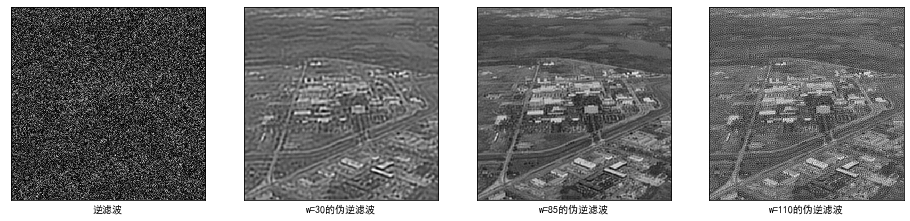

In [11]:
image =cv2.imread('../img/turbulence.png',0)
PSF0 = turbulence_PSF(image,0.0025)          #生成模糊核
PSF = extension_PSF(image,PSF0)    #扩展psf，使其大小与图像大小一致，卷积运算有轻微混迭
blurred = np.abs(make_blurred(image, PSF))  #在频域对图片进行模糊
blurred_noisy = blurred + 0.01 * blurred.std() * \
                np.random.standard_normal(blurred.shape)  # 添加噪声,standard_normal产生随机的函数
imgR0=inverse(blurred_noisy, PSF)
imgR1=Pseudo_inverse(blurred_noisy, PSF, 30,8)
imgR2=Pseudo_inverse(blurred_noisy, PSF, 85,8)
imgR3=Pseudo_inverse(blurred_noisy, PSF, 110,8)
# imgR2=wiener(blurred_noisy, PSF, 1e-3,0.01)
plt.figure(figsize=(16,4))
# plt.subplot(141)
# plt.xlabel("退化图像")
# plt.imshow(blurred_noisy,cmap="gray")
plt.subplot(141)
plt.imshow(imgR0,cmap="gray")
plt.xlabel("逆滤波"),plt.xticks([]), plt.yticks([])
plt.subplot(142)
plt.xlabel("w=30的伪逆滤波"),plt.xticks([]), plt.yticks([])
plt.imshow(imgR1,cmap="gray")
plt.subplot(143)
plt.xlabel("w=85的伪逆滤波"),plt.xticks([]), plt.yticks([])
plt.imshow(imgR2,cmap="gray")
plt.subplot(144)
plt.xlabel("w=110的伪逆滤波"),plt.xticks([]), plt.yticks([])
plt.imshow(imgR3,cmap="gray")
plt.show()

In [12]:
# 调参代码
from chap2_evaluationIndix import *
w=30
for i in range(10):
    w+=5
    k=2
    for j in range(10):
        imgR1=Pseudo_inverse(blurred_noisy, PSF, w,k)
        p1=PSNR(image,imgR1)
        print(w,k,p1)        
        k+=2
    

40 2 26.946096928560447
40 4 28.109777498023792
40 6 28.309448755751013
40 8 27.416684729048406
40 10 25.928931984386402
40 12 24.319245504897914
40 14 22.80165225852466
40 16 21.435908455941256
40 18 20.222928053155023
40 20 19.145160381285
50 2 27.343165802600872
50 4 28.154956609058537
50 6 28.792565845258366
50 8 29.146634050754102
50 10 29.137677607789602
50 12 28.768370237167478
50 14 28.11824483504953
50 16 27.300089964422245
50 18 26.40641773685202
50 20 25.50033638017495
60 2 28.026020896548154
60 4 28.47232398754656
60 6 28.88221125643466
60 8 29.241768408528873
60 10 29.535128640864027
60 12 29.744219441950786
60 14 29.855505877048447
60 16 29.860867090218107
60 18 29.761424527618694
60 20 29.562137793141368
70 2 28.85276157105507
70 4 29.085562773915733
70 6 29.298623681038045
70 8 29.495146404928096
70 10 29.667776042350376
70 12 29.811561274126596
70 14 29.92813925605418
70 16 30.008246438984422
70 18 30.056222057850906
70 20 30.070327888235585
80 2 29.90340048650422
80 4